## Project- AirFares
--- -------------------

### A. Introduction
--- -------------------

This project studies the german domestic airfares during the period 25-10-2019 to 24-04-2020 between major airports in Germany. The aim of the project is to apply the techniques of machine learning on the dataset and understand the trends in pricing with respect to the various features such the booking date, departure & arrival cities, departure time etc. 
#### B. Details of dataset:
-- -------------------
1. Source: [https://www.kaggle.com/datasets/darjand/domestic-german-air-fares](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)
2. Generation mode: web scraping
3. Time period considered: 25-10-2019 to 24-04-2020 (6 months).
4. Total entries: 63,000
5. Features:
    * departure_city: The city from which the flight departs.
    * arrival_city: The city to which the flight arrives.
    * scrape_date: The date when flight price information was retrieved.
    * departure_date: The departure date of the flight (25-10-2019 to 24-04-2020).
    * departure_date_distance: How far in advance (e.g., "1 week") the flight was booked.
    * departure_time: The departure time of the flight.
    * arrival_time: The arrival time of the flight.
    * airline: The airline that operates the flight.
    * stops: The number of layovers or stops during the flight.
    * price (€): The price of the flight ticket in Euros.

#### C. Imports:
-- ----------

In [2]:

#imports


import numpy as np
import pandas as pd
import sklearn.model_selection as ms


import sklearn.feature_extraction.text as text


import sklearn.naive_bayes as nb


import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder


from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.feature_extraction import text


from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from datetime import datetime


import holidays
import time



pd.set_option('display.max_colwidth', 50)

#### D. Load the dataset:
-- ------------------

In [3]:
#Load the data set
df = pd.read_csv('./data/German Air Fares.csv');

#### E. Data Understanding:
-- ----------------------

##### E.1 Basic statistics:

In [4]:
#Basic statistics
df.shape;                                           #--> (62626, 10)
df.info();df.isna().sum();                          #--> (No null objects)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62626 entries, 0 to 62625
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   departure_city           62626 non-null  object
 1   arrival_city             62626 non-null  object
 2   scrape_date              62626 non-null  object
 3   departure_date           62626 non-null  object
 4   departure_date_distance  62626 non-null  object
 5   departure_time           62626 non-null  object
 6   arrival_time             62626 non-null  object
 7   airline                  62626 non-null  object
 8   stops                    62626 non-null  object
 9   price (€)                62626 non-null  object
dtypes: object(10)
memory usage: 4.8+ MB


##### E.2 Understanding departure and arrival cities
-- ----------------------

In [5]:
df.departure_city.unique();
# a. Extract departure city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['departure_city'] = df['departure_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

df.arrival_city.unique();
# b. Extract arrival city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['arrival_city'] = df['arrival_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

# c. Replace departure & arrival cities with their respective rankings
airport_ranking = pd.read_csv("./data/German Airport Ranking.csv")
airport_ranking_dict = dict(
    zip(airport_ranking['Airport'], airport_ranking['Rank']))

df['departure_city'] = df['departure_city'].map(airport_ranking_dict)
df['arrival_city'] = df['arrival_city'].map(airport_ranking_dict)

##### E.2 Conclusion: 
* **ToDos:**
    * *A histogram showing distribution of departure and arrival cities would be interesting.*</font>

##### E.3 Understanding departure and scrape dates
-- ----------------------

In [6]:
# a. Departure dates: Find the departure date frequencies: How spread are they?
dep_dates = pd.to_datetime(df['departure_date'], dayfirst=True);
dep_dates = sorted(dep_dates.unique()); 
dep_dates = pd.Series(dep_dates);
dep_dates.shape;                                    
dep_dates.diff(periods=1).unique();        

# b. Scrape dates: Find the scrape date frequencies: How spread are they?
scrape_dates = pd.to_datetime(df['scrape_date'], dayfirst=True);
scrape_dates = sorted(scrape_dates.unique()); 
scrape_dates = pd.Series(scrape_dates);
scrape_dates.shape;                                    
scrape_dates.diff(periods=1).unique();
# -------------------------------------------------------
# c. Convert all date data into date-time format
df.departure_date = pd.to_datetime(df.departure_date, dayfirst=True);
df.scrape_date = pd.to_datetime(df.scrape_date, dayfirst=True);

# c. Sort the dataframe according to departure dates
df.sort_values(by='departure_date', inplace = True)
#print('Dataframe sorted according to departure date: ',df.departure_date.is_monotonic_increasing); #-> True

#--> Additionally, it was verified that there are no illegal date values.

##### E3: Conclusion: 
* **Departure dates:**
    * 42 unique departure dates
    * departure date frequencies are not unique -> ['1 days', '11 days', '5 days', '44 days', '85 days']
* **Scrape dates:**
    * scrape date frequencies are only from 18-24.10.2019
    * scrape date frequencies are unique -> 1 day

##### E.4 Understanding departure_date_distance
-- ----------------------

In [7]:
df.departure_date_distance.value_counts();           
#--> 
# 6 months    12672
# 6 weeks     11222
# 1 month     10092
# 1 week       9949
# 3 month      9748
# 2 weeks      7850
# 2 week       1093

# Replace vague departure_date_distance (weeks, months etc.) with differences as days 
df.departure_date_distance =  (df['departure_date'] - df['scrape_date']).dt.days

##### E.5 Understanding departure and arrival times
-- ----------------------

In [8]:
# a. Uniformize time formats ('Uhr', am/pm) into xx:xx 24-hour format
def convert_to_24_hour_format(time_str):
    if 'Uhr' in time_str:
        return datetime.strptime(time_str, '%H:%M Uhr').strftime('%H:%M')
    else:
        return datetime.strptime(time_str, '%I:%M%p').strftime('%H:%M')

# Convert departure time column to 24-hour format
df['departure_time'] = df['departure_time'].apply(convert_to_24_hour_format)
df['arrival_time'] = df['arrival_time'].apply(convert_to_24_hour_format)

# Strip only the hour (to make matters simple)
df['departure_time_hour'] = df['departure_time'].apply(lambda x: int(x.split(':')[0]))

##### E.6 Understanding Airlines
-- ---------------------------------------------

In [9]:
# a. Drop rows with 'Mehrere Fluglinien' and 'Multiple airlines'

df = df[~df['airline'].isin(['Mehrere Fluglinien', 'Multiple Airlines'])]
df['airline'] = df['airline'].replace('easyJet', 'EasyJet')

# b. Convert airlines into their respective ranks (numerical representation)
airport_ranking = pd.read_csv("./data/Airline Ranking.csv")
Airline_ranking_dict = dict(
    zip(airport_ranking['airline'], airport_ranking['rank']))

df['airline'] = df['airline'].map(Airline_ranking_dict)

##### E.6 Conclusion:
* **Airlines:**
    * There were 69 'Mehrere Fluglinien' and 153 'Multiple Airlines', these entries were removed.    

##### E.7 Understanding stops
---------------------------------------------

In [10]:
# Stops are converted into numerical values
# 0, 1 and 2 stops.
def countStops(stop):
    if 'direct' in stop:
        return 0
    elif '1' in stop:
        return 1
    elif '2' in stop:
        return 2
    
df['stops'] = df['stops'].apply(countStops)

##### E8. Understanding prices
--------------------------


In [11]:
# a. Rename 'price (€)' to 'price'
df = df.rename(columns={'price (€)': 'price'});

# b. format into int properly
df['price'] = df['price'].str.replace(',', '').astype(int)

##### E.8 Conclusion:
* prices are, of course, the target value

### F. New Features:
-- -----------

##### F.1: Departure weekdays

In [12]:
#  week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. 
if 'departure_weekday' not in df.columns:
    df.insert(5,'departure_weekday', df.departure_date.dt.weekday)

##### F.2: days_until_a_holiday

In [13]:
# Create a holidays list for Germany for the years 2019 & 2020.
# Only the national holidays as provided by the holidays library are taken into account. They are:
# date	holiday
# 0	    2019-01-01	Neujahr
# 1	    2019-04-19	Karfreitag
# 2	    2019-04-22	Ostermontag
# 3	    2019-05-01	Erster Mai
# 4	    2019-05-30	Christi Himmelfahrt
# 5	    2019-06-10	Pfingstmontag
# 6	    2019-10-03	Tag der Deutschen Einheit
# 7	    2019-12-25	Erster Weihnachtstag
# 8	    2019-12-26	Zweiter Weihnachtstag
#----------------------------------------
# 9	    2020-01-01	Neujahr
# 10	2020-04-10	Karfreitag
# 11	2020-04-13	Ostermontag
# 12	2020-05-01	Erster Mai
# 13	2020-05-21	Christi Himmelfahrt
# 14	2020-06-01	Pfingstmontag
# 15	2020-10-03	Tag der Deutschen Einheit
# 16	2020-12-25	Erster Weihnachtstag
# 17	2020-12-26	Zweiter Weihnachtstag

holiday_list = list(holidays.Germany(years=[2019, 2020]).items())

holidays_df = pd.DataFrame(holiday_list, columns=['date','holiday'])
holidays_df.date = pd.to_datetime(holidays_df.date)

# Sort holidays_df by date
holidays_df = holidays_df.sort_values(by='date')

# Define a function to find the next holiday
def find_next_holiday(departure_date):
    return holidays_df[holidays_df['date'] >= departure_date].iloc[0]['date']

# Apply the function to get the 'next_holiday'
df['next_holiday'] = df['departure_date'].apply(find_next_holiday)

# Calculate the difference between the two dates to get the 'days_until_holiday'
df['days_until_holiday'] = (df['next_holiday'] - df['departure_date']).dt.days

##### F.3: travel_time

In [14]:
# Calculate the difference between departure and arrival times in hours
df['travel_time'] = (pd.to_datetime(df['arrival_time'], format='%H:%M') - pd.to_datetime(df['departure_time'], format='%H:%M')).dt.total_seconds() / 3600

# Normalize the travel time
df['travel_time'] =  df['travel_time'].apply(lambda x: round(x, 2))

### G. Random Forests to predict the price of the flights:
-------------------------------------------



In [15]:
df = df.drop(['scrape_date', 'departure_date', 'next_holiday',
             'departure_time', 'arrival_time'], axis=1)
df = df[['departure_city', 'arrival_city',	'departure_date_distance',	'departure_weekday',
         'departure_time_hour', 'travel_time', 'days_until_holiday', 'airline',	'stops', 'price']]
y = df['price']
X = df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

1463.8916283939986 100


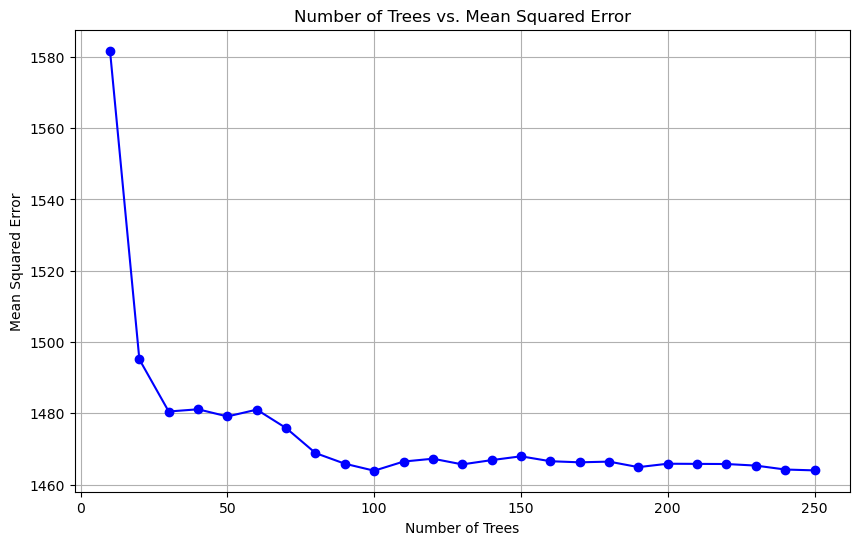

In [16]:
num_trees_list = []
mse_list = []
step = 10
for i in range(10, 251, step):
    regressor = RandomForestRegressor(
        n_estimators=i, random_state=42, n_jobs=-3)

    # Train the regressor on the training data
    regressor.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = regressor.predict(X_test)

    mse = mean_squared_error(y_test, predictions)

    num_trees_list.append(i)
    mse_list.append(mse)
    
    if step > 50: step = 25
    if step > 200: step = 50
    
print(min(mse_list), num_trees_list[mse_list.index(min(mse_list))])
plt.figure(figsize=(10, 6))
plt.plot(num_trees_list, mse_list, marker='o', linestyle='-', color='b')
plt.title('Number of Trees vs. Mean Squared Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

Plot shows that the forest with 100 trees has the best result.
So let us model it and visualize the predictions.

In [23]:
    regressor = RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-3, oob_score=True)

    # Train the regressor on the training data
    regressor.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = regressor.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(mse, r2)
    

1463.8916283939986 0.9500127743414716


GridSearchCV to find best params

In [27]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Perform the grid search
grid_search.fit(X, y)

scores = []

# Iterate over each score from the grid search
for score in grid_search.cv_results_['mean_test_score']:
    # Convert the score to positive
    score = -score
    # Add the score to the scores list
    scores.append(score)

# Print the best parameters and the corresponding oob score
print("Best Parameters: ", grid_search.best_params_)
print("Best OOB Score: ", grid_search.best_score_)
print("Best Model: ", grid_search.best_estimator_)
print("scores", scores)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best OOB Score:  -4688.450564300525
Best Model:  RandomForestRegressor(min_samples_split=5, n_jobs=-3, oob_score=True,
                      random_state=42)
scores [4755.189378922076, 4688.450564300525, 4750.093349715332, 4762.450142182649, 4773.488733858036, 4798.299996317854, 4799.851064562323, 4799.851064562323, 4780.191183333411, 7303.366817769218, 7303.176494189416, 7303.215259815037, 7302.866861812117, 7302.866980483052, 7302.922931063724, 7303.9334637037655, 7303.9334637037655, 7303.935458647078, 5811.433553069406, 5789.833596426755, 5799.249972961518, 5791.454217610308, 5787.811097015499, 5806.636920487321, 5786.750321684666, 5786.750321684666, 5789.2504524543665, 5065.9943556914495, 5037.909442845275, 5042.274870631609, 5068.295933368688, 5067.568908970103, 5052.956533293369, 5063.789552916436, 5063.789552916437, 5085.960691022023]


Best regressor that we have so far

In [33]:
regressor = RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-3, oob_score=True, min_samples_leaf=1, min_samples_split=5)

    # Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(mse, r2)

1459.373763897953 0.9501670449907998


**Trying k fold cv to check for overfitting**

In [34]:
num_folds = 10  # You can adjust this number based on your preference

# Create a cross-validation object (here using KFold)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=kf,
                            scoring='neg_mean_squared_error')

# Convert negative MSE to positive (as cross_val_score returns negative MSE)
cv_scores = -cv_scores

# Print the cross-validation scores
print("Cross-Validation Scores:")
print(cv_scores)

Cross-Validation Scores:
[1287.15702896 1464.31864447 1451.65703401 1448.41668364 1494.82000827
 1383.22199853 1378.86203889 1473.6030205  1438.04220466 1417.12318966]


Learning Curve Visualization 
--

FOR JOSSIN!!
This might indicate overfitting, I'm not sure if we should keep this.

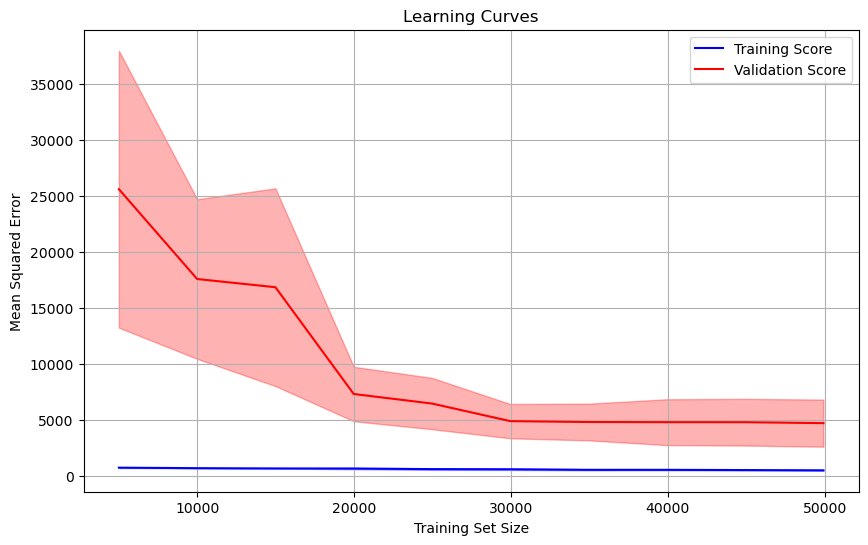

In [72]:
train_sizes, train_scores, val_scores = learning_curve(
    regressor, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Convert negative MSE to positive
train_scores = -train_scores
val_scores = -val_scores

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.3, color='red')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Best model r2 score

In [38]:
print("Best Model: ", grid_search.best_estimator_.oob_score_)

Best Model:  0.9519008315944342


Plotting the residuals

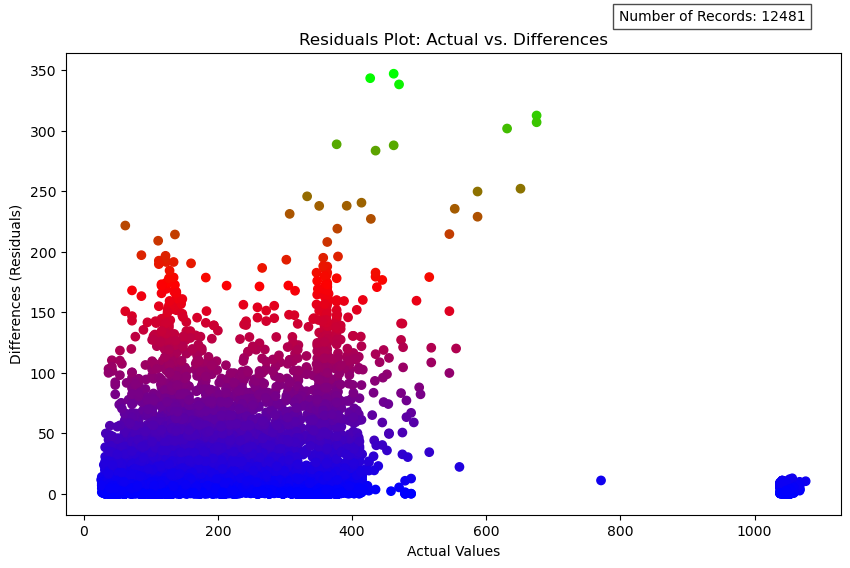

In [40]:
differences = abs(predictions - y_test)


# Calculate normalized differences for color mapping
normalized_differences = differences / differences.max()

# Map normalized differences to a colormap (e.g., red shades)
colors = plt.cm.brg(normalized_differences)

# Create a scatter plot of differences
plt.figure(figsize=(10, 6))
num_records = len(y_test)
plt.text(max(y_test), 400, f'Number of Records: {num_records}', ha='right',
         va='top', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.scatter(y_test, differences, color=colors, alpha=1)
plt.title('Residuals Plot: Actual vs. Differences')
plt.xlabel('Actual Values')
plt.ylabel('Differences (Residuals)')

plt.show()

A humble attempt in introducing weighted voting, also barely beneficial

In [70]:

def calculate_oob_error(tree, X_train, y_train):
    # Predict on the out-of-bag samples
    oob_mask = np.ones(X_train.shape[0], dtype=bool)
    oob_mask[np.unique(np.where(tree.apply(X_train) == 0)[0])] = False
    oob_predictions = tree.predict(X_train[oob_mask])

    # Calculate OOB error (e.g., mean squared error)
    oob_error = mean_squared_error(y_train[oob_mask], oob_predictions)

    return oob_error

def custom_rf_predict(X, trees, weights):
    predictions = np.zeros(X.shape[0])
    total_weight = 0

    for tree, weight in zip(trees, weights):
        predictions += tree.predict(X) * weight
        total_weight += weight

    return predictions / total_weight

class w_rf(RandomForestRegressor):

    def predict(self, regressor, X_train, y_train):
        # Get the list of decision trees in the Random Forest
        trees = regressor.estimators_

        # Calculate the out-of-bag error for each tree
        oob_errors = [calculate_oob_error(
            tree, X_train, y_train) for tree in trees]

        # Normalize OOB errors to get weights
        weights = np.array(oob_errors)
        weights = 2 / (1 + weights)

        predictions = custom_rf_predict(X_train, trees, weights)
        
        return predictions

# Create a Random Forest Regressor with 100 trees
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=5, n_jobs=-3, oob_score=True)

X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# Train the initial Random Forest Regressor
rf_regressor.fit(X_train_np, y_train_np)

# Display the mean squared error before adjusting weights
print("Before Weight Adjustment - Mean Squared Error on Test Set:",
      mean_squared_error(y_test_np, rf_regressor.predict(X_test_np)))

# Adjust weights based on OOB errors
w_rf_regressor = w_rf(n_estimators=100, random_state=42, min_samples_split=5, n_jobs=-3, oob_score=True)

w_rf_regressor.fit(X_train_np, y_train_np)

# Display the mean squared error after adjusting weights
print("After Weight Adjustment - Mean Squared Error on Test Set:",
      mean_squared_error(y_test_np, w_rf_regressor.predict(w_rf_regressor, X_test_np, y_test_np)))

Before Weight Adjustment - Mean Squared Error on Test Set: 1459.373763897953
After Weight Adjustment - Mean Squared Error on Test Set: 1457.7205479286977
